In [2]:
#This cell imports all the necessary packages and the lower half formats the plots being made in this notebook
import pandas as pd 
import numpy as np
from datetime import datetime
import datatools
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import pvlib
import pvanalytics
import math

%matplotlib inline 
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

mpl.rcParams['font.size']=12
mpl.rcParams['lines.linewidth']=1
mpl.rcParams['xtick.labelsize']=10
#mpl.rcParams['font.weight']='bold'
mpl.rcParams['axes.titlesize']=22

In [3]:
engine = datatools.database.create_mss_engine()
#Accessing databases require the creation of an engine, datatools has a specific function to do that for an SQL server database
# on the SRN database. If you want to see all database options run:
#datatools.database.get_all_tables(engine)

In [4]:
#Start by identifying the desired table for the meteorological data 
tablename = 'dbo.SNLA_Met_DataOut'
#If you needed the column info you could uncomment:
##column_info = datatools.database.get_columns_from_table(table = tablename,
##                       engine=engine
##                      )
##[column[3] for column in column_info]#Start by identifying the desired table for the meteorological data 
#We can now import the data we want from the table defined above
start = '2020-03-01 00:00:00'
end = '2021-02-28 00:00:00'
met_sql = f"select * from {tablename} where TmStamp between '{start}' and '{end}';"
met = pd.read_sql(met_sql, engine, index_col='TmStamp')
met.index = pd.DatetimeIndex(met.index)
met.index = met.index.tz_localize('MST') 
[met.index.min(),  met.index.max()]

[Timestamp('2020-03-01 00:00:00-0700', tz='MST'),
 Timestamp('2021-02-28 00:00:00-0700', tz='MST')]

In [5]:
#Then identify the table of system data to be used
tablename = 'dbo.PVLT_Pan_LG_Panasonic_LG'
#If you needed the column info you could uncomment:
##column_info = datatools.database.get_columns_from_table(table = tablename,
##                       engine=engine
##                      )
##[column[3] for column in column_info]
#We can import the same time frame of data from our system as we did the meteo data
start = '2020-03-01 00:00:00'
end = '2021-02-28 23:59:00'
sys_sql = f"select * from {tablename} where TmStamp between '{start}' and '{end}';"
sys = pd.read_sql(sys_sql, engine, index_col='TmStamp')
sys.index = pd.DatetimeIndex(sys.index)
sys.index = sys.index.tz_localize('MST')
[sys.index.min(),  sys.index.max()]

[Timestamp('2020-03-01 00:00:00-0700', tz='MST'),
 Timestamp('2021-02-28 23:59:00-0700', tz='MST')]

In [6]:
#This merges the met and system data into one dataframe 
df = pd.merge(met,sys,how='inner', left_index=True, right_index=True)
df.columns

Index(['RecNum_x', 'Global_Wm2_Avg', 'Direct_Wm2_Avg', 'Diffuse_Wm2_Avg',
       'Pressure_mBar_Avg', 'WS_ms_Mean', 'Wdir_Mean', 'Wdir_Std', 'WS_ms_Std',
       'WS_ms_3sec_Max', 'WD_deg_SMM', 'Temp_C_Avg', 'RH_pct_Avg',
       'Panel_Temp_C_Avg', 'Battery_V_Avg', 'ProcessTime_S_Max',
       'Global_mV_Avg', 'Rain_mm_Tot', 'Rain_mm_Daily', 'Temp_CMP22_C_Avg',
       'RecNum_y', 'BroadbandPOA_Avg', 'POACleanRC_E_Avg', 'GHI_Avg',
       'Albedo_Avg', 'AmbientTemp_Avg', 'PH1_V_Avg', 'PH2_V_Avg', 'PH3_V_Avg',
       'PH4_V_Avg', 'LM1_V_Avg', 'LM2_V_Avg', 'LM3_V_Avg', 'LM4_V_Avg',
       'PH1_I_Avg', 'PH2_I_Avg', 'PH3_I_Avg', 'PH4_I_Avg', 'LM1_I_Avg',
       'LM2_I_Avg', 'LM3_I_Avg', 'LM4_I_Avg', 'PH1_RTD_Avg', 'PH2_RTD_Avg',
       'PH3_RTD_Avg', 'PH4_RTD_Avg', 'LM1_RTD_Avg', 'LM2_RTD_Avg',
       'LM3_RTD_Avg', 'LM4_RTD_Avg', 'Wind_Speed_Avg', 'Wind_Direction_Avg',
       'Wind_Dir_std', 'Wind_Gust_Max'],
      dtype='object')

In [7]:
#Calculate SunPositions
latitude = 35.05
longitude = -106.54
solpos = pvlib.solarposition.get_solarposition(df.index, latitude, longitude, df['Pressure_mBar_Avg'],)
dni_extra = pvlib.irradiance.get_extra_radiation(df.index)

In [8]:
solpos.head(25)

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
TmStamp,,,,,,
2020-03-01 00:00:00-07:00,152.008580,152.008580,-62.008580,-62.008580,350.219286,-12.282749
2020-03-01 00:01:00-07:00,152.042167,152.042167,-62.042167,-62.042167,350.743011,-12.282613
2020-03-01 00:02:00-07:00,152.073905,152.073905,-62.073905,-62.073905,351.267823,-12.282476
2020-03-01 00:03:00-07:00,152.103788,152.103788,-62.103788,-62.103788,351.793665,-12.282339
2020-03-01 00:04:00-07:00,152.131810,152.131810,-62.131810,-62.131810,352.320477,-12.282202
2020-03-01 00:05:00-07:00,152.157965,152.157965,-62.157965,-62.157965,352.848199,-12.282066
2020-03-01 00:06:00-07:00,152.182247,152.182247,-62.182247,-62.182247,353.376772,-12.281929
2020-03-01 00:07:00-07:00,152.204652,152.204652,-62.204652,-62.204652,353.906134,-12.281792
2020-03-01 00:08:00-07:00,152.225176,152.225176,-62.225176,-62.225176,354.436224,-12.281655


(-10.0, 1500.0)

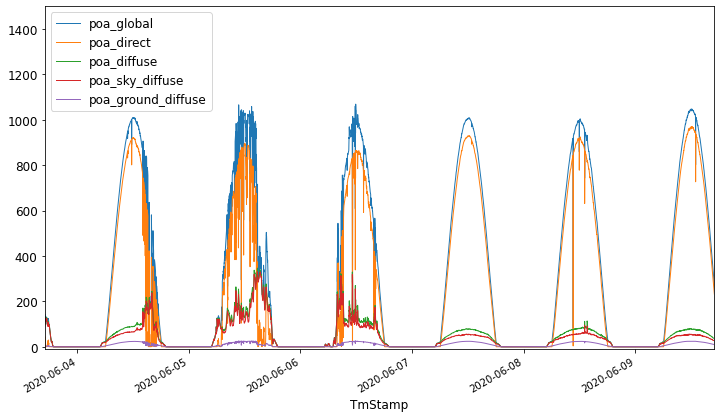

In [9]:
#Calculate Plane of Array (POA) Irradiance
tilt = 35
surface_azimuth = 180
altitude = 1600
#dni_extra = pvlib.irradiance.get_extra_radiation(newdf.index)
total_irrad = pvlib.irradiance.get_total_irradiance(tilt,surface_azimuth,
        solpos['apparent_zenith'],
        solpos['azimuth'],
        df.Direct_Wm2_Avg, 
        df.Global_Wm2_Avg, 
        df.Diffuse_Wm2_Avg,
        dni_extra,
        model='haydavies')

total_irrad.plot(figsize=(12,7))
plt.xlim('2020-06-04','2020-06-10')
plt.ylim(-10,1500)

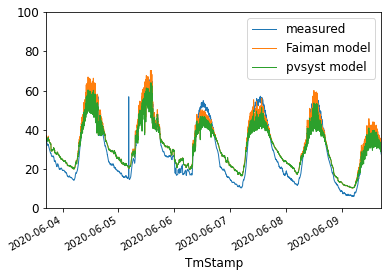

In [10]:
#Calculate Module and Cell Temperature using Faiman Temperature Model
# Model Module temperature
U0 = 24.614 #CFV report
U1 = 7.878 #CFV report
T_faiman = pvlib.temperature.faiman(
    df.BroadbandPOA_Avg, df.AmbientTemp_Avg, df.Wind_Speed_Avg,U0,U1)
T_pvsyst_cell = pvlib.temperature.pvsyst_cell(
    df.BroadbandPOA_Avg, df.AmbientTemp_Avg, df.Wind_Speed_Avg, u_c=U0, u_v=U1, eta_m=0.1, alpha_absorption=0.9)
T_meas = df['PH1_RTD_Avg'].copy()

# Plot measured and modeled temperature
T_meas.plot(label='measured')
T_faiman.plot(label='Faiman model')
T_pvsyst_cell.plot(label='pvsyst model')
plt.xlim('2020-06-04','2020-06-10')
plt.ylim(0,100)
plt.legend(loc='best')

(18417.0, 18423.0)

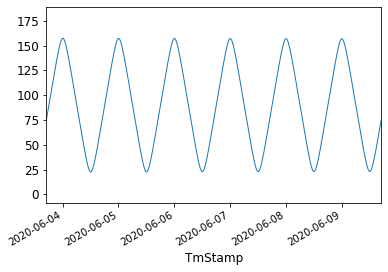

In [11]:
#Calculate angle of incidence (aoi)
aoi = pvlib.irradiance.aoi(tilt, surface_azimuth, solar_zenith=solpos['apparent_zenith'],
        solar_azimuth=solpos['azimuth'])
aoi.plot()
plt.xlim('2020-06-04','2020-06-10')

(18417.0, 18423.0)

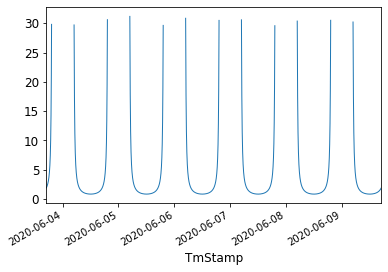

In [12]:
#Calculate absolute airmass
airmass = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])
pressure = pvlib.atmosphere.alt2pres(altitude)
am_abs = pvlib.atmosphere.get_absolute_airmass(airmass, pressure)
am_abs.plot()
plt.xlim('2020-06-04','2020-06-10')

In [13]:
#Define the inverter parameters & create a dataframe for inverter info
inverter = {"Vac":480, "Paco":20000, "Pdco":20400, "Vdcmax":1000 ,"Idcmax":66 , "Mppt_low":380 , "Mppt_high":800, "Pnt":0.075,
           "Pso":2.089, "Vdco":150, "C0":0, "C1":0, "C2":0, "C3":0}

In [14]:
#Model cell and module temperature
temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']
tcell = pvlib.temperature.sapm_cell(total_irrad['poa_global'],
            df.AmbientTemp_Avg, df.Wind_Speed_Avg,
            **temperature_model_parameters)

In [15]:
#Define Panasonic Module Parameters & create a dataframe for module info
module = {"Vintage":"2016", "Area":"1.67", "Material": "HIT", "Cells_in_Series":96, "Parallel_Strings":1, "Isco":5.87, 
          "Voco":69.67, "Impo":5.48, "Vmpo":57.72, "Aisc":0.000711, "Aimp":0.0003836, "C0":0.994695, "C1":0.005305,
          "Bvoco":-0.171865, "Mbvoc":0, "Bvmpo":-0.1689897, "Mbvmp":0, "N":0.97, "C2":-0.15253, "C3":-15.838,
          "A0":0.95159011, "A1":0.035565004, "A2":-0.001762823, "A3":-0.00033466, "A4":0.00003125,  "A":-3.40567, "B":-0.11234,
         "B5":-2.33454E-09, "B4":3.76061E-07, "B3":-2.16746E-05, "B2":0.000497174, "B1":-0.003944734, "B0":1, "FD":1,
         "IXO":0, "IXXO":0, "C4":0, "C5":0, "C6":0, "C7":0}

In [16]:
#Calculating the effective irradiance, then calculating the dc power out put of modules & ac output of inverters
pan_effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(
            total_irrad['poa_direct'], total_irrad['poa_diffuse'],
            am_abs, aoi, module)
pan_dc = pvlib.pvsystem.sapm(pan_effective_irradiance, tcell, module)
pan_ac = pvlib.inverter.sandia(pan_dc['v_mp'], pan_dc['p_mp'], inverter)

Text(0, 0.5, 'Power')

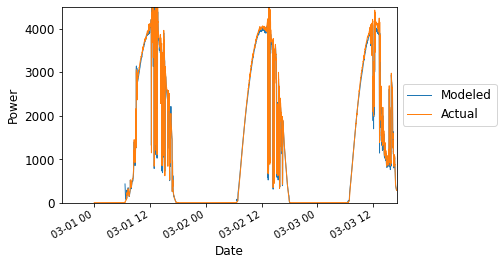

In [17]:
#Account for 4 strings of 12 Panasonic modules
#Modeled Panasonic String Voltage and Power
mpan_string_v = pan_dc['v_mp']*12
mpan_string_p = pan_dc['i_mp']*mpan_string_v
#Actual Panasonic String Power from df
apan_string_p = df['PH4_V_Avg']*df['PH4_I_Avg']


#Plot the modeled vs actual performance
mpan_string_p.plot(label = 'Modeled')
apan_string_p.plot(label = 'Actual')
plt.xlim('2020-03-01', '2020-03-04')
plt.ylim(0,4500)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.xlabel('Date')
plt.ylabel('Power')

Text(0, 0.5, 'Ratio of Measured to Modeled Power')

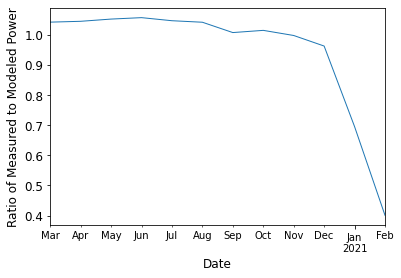

In [18]:
#Resample the data to get the sum of all power produced in a month
#Monthly Modeled Panasonic String Power
mmpan_string_p = mpan_string_p.resample('M').sum()
#Monthly Actual Panasonic String Power
mapan_string_p = apan_string_p.resample('M').sum()

#Plot the modeled power against the actual power
#pan_monthly_string_p.plot(label = 'Modeled')
#pan_actual_monthly.plot(label = 'Actual')
#plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
#plt.xlabel('Date')
#plt.ylabel('Voltage')

#Plot the ratio of measured power to modeled power
ratio = (mapan_string_p/mmpan_string_p)
ratio.plot()
plt.xlabel('Date')
plt.ylabel('Ratio of Measured to Modeled Power')

In [19]:
#Generate a DateTime Index for the SAM data
date_rng = pd.date_range(start='3/1/2020', end='3/1/2021', freq='H')
date_rng = date_rng.drop(pd.Timestamp('2021-03-01 00:00:00'))
#Import SAM data and assign the new index to it
results = pd.read_csv('results.csv')
results.index = date_rng
results.index = results.index.tz_localize('MST')
#Resample system data to be in the same timestep as the SAM data
apanh = apan_string_p.resample('H').mean()
mpanh = mpan_string_p.resample('H').mean()
results['Measured'] = apanh.to_frame()
results['SAPM'] = mpanh.to_frame()

Text(0, 0.5, 'Power (W)')

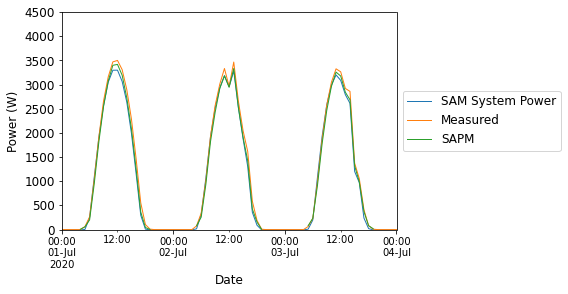

In [20]:
#Plot SAM, Measured, and SAPM values 
results.plot()
plt.xlim('2020-07-01', '2020-07-04')
plt.ylim(0,4500)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.xlabel('Date')
plt.ylabel('Power (W)')

(-4500.0, 1500.0)

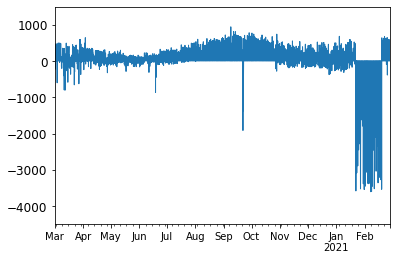

In [21]:
#Plots the difference between SAM & Measured power to detect large differences which could indicate erroneous data
difference = results['Measured'] - results['SAM System Power']
#difference = panh - mpanh
difference.plot()
plt.xlim('2020-03-01', '2021-02-28')
plt.ylim(-4500,1500)

<AxesSubplot:xlabel='SAM System Power', ylabel='Measured'>

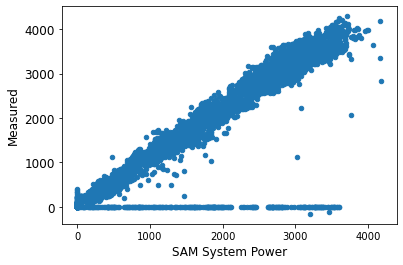

In [22]:
#Plot modeled vs measured power to see the linearity 
results.plot.scatter('SAM System Power','Measured')

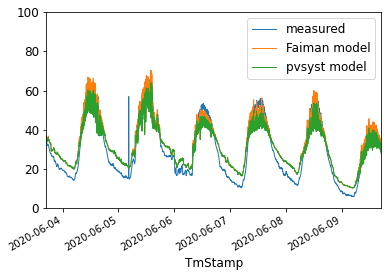

In [23]:
#Calculate Module and Cell Temperature using Faiman Temperature Model
##NEED TO UPDATE COEFFICIENTS FOR LG MODULES, NEED LOCATION
# Model Module temperature
U0 = 24.614 #CFV report
U1 = 7.878 #CFV report
T_faiman = pvlib.temperature.faiman(
    df.BroadbandPOA_Avg, df.AmbientTemp_Avg, df.Wind_Speed_Avg,U0,U1)
T_pvsyst_cell = pvlib.temperature.pvsyst_cell(
    df.BroadbandPOA_Avg, df.AmbientTemp_Avg, df.Wind_Speed_Avg, u_c=U0, u_v=U1, eta_m=0.1, alpha_absorption=0.9)
T_meas = df['LM1_RTD_Avg'].copy()

# Plot measured and modeled temperature
T_meas.plot(label='measured')
T_faiman.plot(label='Faiman model')
T_pvsyst_cell.plot(label='pvsyst model')
plt.xlim('2020-06-04','2020-06-10')
plt.ylim(0,100)
plt.legend(loc='best')

In [24]:
#Define LG Module Parameters & create a dataframe for module info
module = {"Vintage":"2017", "Area":"1.71", "Material": "c-Si", "Cells_in_Series":60, "Parallel_Strings":1, "Isco":10.15, 
          "Voco":39.94, "Impo":9.64, "Vmpo":32.48, "Aisc":0.000706, "Aimp":0.0003228, "C0":1.014279, "C1":-0.01428,
          "Bvoco":-0.111204, "Mbvoc":0, "Bvmpo":-0.1185716, "Mbvmp":0, "N":0.96, "C2":-0.40033, "C3":-14.7721,
          "A0":0.967748, "A1":0.023426, "A2":-0.0008, "A3":-0.00037, "A4":0.00003219, "A":-3.57414, "B":-0.1184, 
         "B5":-1.49207E-09, "B4":2.33152E-07, "B3":-1.35142E-05, "B2":0.000313806, "B1":-0.00248674, "B0":1, "FD":1,
         "IXO":0, "IXXO":0, "C4":0, "C5":0, "C6":0, "C7":0}

In [25]:
#Calculating the effective irradiance, then calculating the dc power out put of modules & ac output of inverters
lg_effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(
            total_irrad['poa_direct'], total_irrad['poa_diffuse'],
            am_abs, aoi, module)
lg_dc = pvlib.pvsystem.sapm(lg_effective_irradiance, tcell, module)
lg_ac = pvlib.inverter.sandia(lg_dc['v_mp'], lg_dc['p_mp'], inverter)

Text(0, 0.5, 'Power')

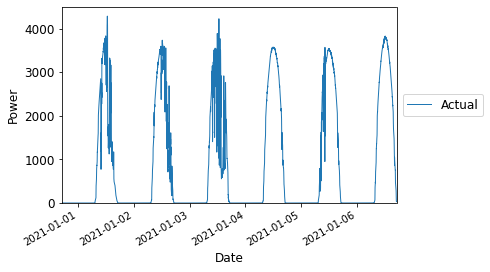

In [26]:
#Account for 4 strings of 12 LG modules
lg_string_v = lg_dc['v_mp']*12
lg_string_p = lg_dc['i_mp']*lg_string_v
lg_actual_p = df['LM1_V_Avg']*df['LM1_I_Avg']


#Plot the modeled vs actual performance
#lg_string_p.plot(label = 'Modeled')
lg_actual_p.plot(label = 'Actual')
plt.xlim('2021-01-01', '2021-01-07')
plt.ylim(0,4500)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.xlabel('Date')
plt.ylabel('Power')

Text(0, 0.5, 'Ratio of Measured to Modeled Power')

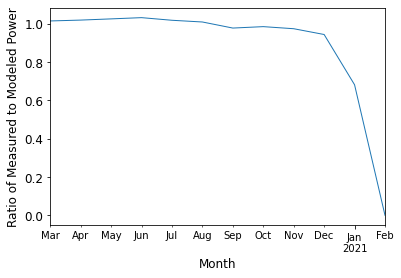

In [27]:
#Resample the data to get the sum of all power produced in a month
lg_model_monthly = lg_string_p.resample('M').sum()
lg_actual_monthly = lg_actual_p.resample('M').sum()

#lg_monthly_string_p.plot(label = 'Modeled')
#lg_actual_monthly.plot(label = 'Actual')
#plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
#plt.xlabel('Date')
#plt.ylabel('Power')

#Plot the ratio of measured power to modeled power
ratio = (lg_actual_monthly/lg_model_monthly)
ratio.plot()
plt.xlabel('Month')
plt.ylabel('Ratio of Measured to Modeled Power')

In [28]:
#Generate a DateTime Index for the SAM data
date_rng = pd.date_range(start='3/1/2020', end='3/1/2021', freq='H')
date_rng = date_rng.drop(pd.Timestamp('2021-03-01 00:00:00'))
#Import SAM data and assign the new index to it
lgresults = pd.read_csv('lgresults.csv')
lgresults.index = date_rng
lgresults.index = lgresults.index.tz_localize('MST')
#Resample system data to be in the same timestep as the SAM data
algh = lg_actual_p.resample('H').mean()
mlgh = lg_string_p.resample('H').mean()
lgresults['Measured'] = algh.to_frame()
lgresults['Modeled'] = mlgh.to_frame()

Text(0, 0.5, 'Power (W)')

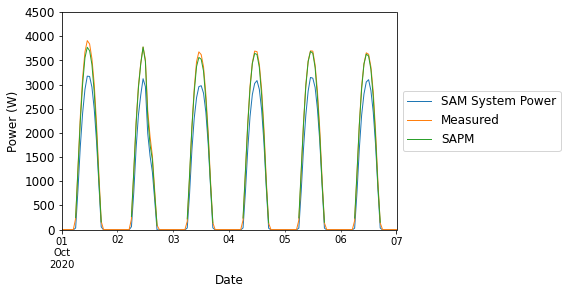

In [29]:
#Plot SAM, Measured, and SAPM values 
results.plot()
plt.xlim('2020-10-01', '2020-10-07')
plt.ylim(0,4500)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.xlabel('Date')
plt.ylabel('Power (W)')

<AxesSubplot:>

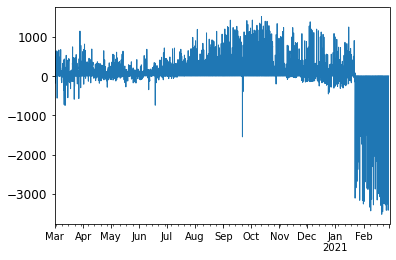

In [30]:
lgdifference = lgresults['Measured'] - lgresults['SAM System Power']
lgdifference.plot()

<AxesSubplot:xlabel='SAM System Power', ylabel='Measured'>

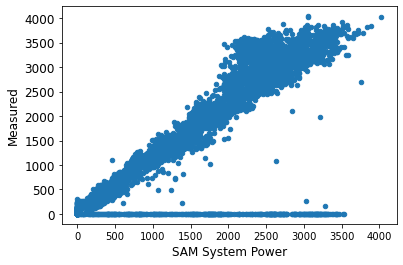

In [31]:
#Plot modeled vs measured power to see the linearity 
lgresults.plot.scatter('SAM System Power','Measured')

In [32]:
wdf = np.radians(solpos['apparent_zenith'])
wdf = wdf.to_frame()
wdf['GHI'] = df['Global_Wm2_Avg']
wdf['DNI'] = df['Direct_Wm2_Avg']
wdf['DHI'] = df['Diffuse_Wm2_Avg']
wdf['GHI Calc'] = (wdf['DHI']) + ((wdf['DNI'])*np.cos(wdf['apparent_zenith']))
wdf['DNI Calc'] = pvlib.irradiance.dni(wdf['GHI'], wdf['DHI'], solpos['apparent_zenith'])
wdf['DHI Calc'] = (wdf['GHI']) - ((wdf['DNI'])*np.cos(wdf['apparent_zenith']))
wdf['% Error GHI'] = ((wdf['GHI'] - wdf['GHI Calc'])/(wdf['GHI Calc']))*100
wdf['% Error DNI'] = ((wdf['DNI'] - wdf['DNI Calc'])/(wdf['DNI Calc']))*100
wdf['% Error DHI'] = ((wdf['DHI'] - wdf['DHI Calc'])/(wdf['DHI Calc']))*100

(0.0, 1050.0)

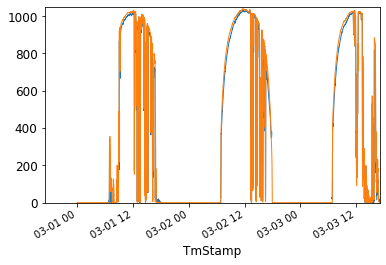

In [33]:
wdf['DNI Calc'].plot()
wdf['DNI'].plot()
plt.xlim('2020-03-01', '2020-03-04')
plt.ylim(0,1050)

In [34]:
wdf.head(950)

,apparent_zenith,GHI,DNI,DHI,GHI Calc,DNI Calc,DHI Calc,% Error GHI,% Error DNI,% Error DHI
TmStamp,,,,,,,,,,
2020-03-01 00:00:00-07:00,2.653050,-4.932866,0.295596,-4.988518,-5.249535,NaN,-4.671849,-6.032332,NaN,6.778245
2020-03-01 00:01:00-07:00,2.653636,-4.939567,0.323702,-5.378273,-5.664196,NaN,-4.653644,-12.793147,NaN,15.571217
2020-03-01 00:02:00-07:00,2.654190,-4.918877,0.402402,-4.761809,-5.117352,NaN,-4.563334,-3.878474,NaN,4.349346
2020-03-01 00:03:00-07:00,2.654712,-4.879689,0.284153,-5.117575,-5.368708,NaN,-4.628556,-9.108692,NaN,10.565263
2020-03-01 00:04:00-07:00,2.655201,-4.868735,0.275014,-4.653722,-4.896841,NaN,-4.625616,-0.573973,NaN,0.607628
...,...,...,...,...,...,...,...,...,...,...
2020-03-01 15:45:00-07:00,1.123019,458.195923,905.608643,76.674973,468.770229,881.185539,66.100666,-2.255755,2.771619,15.997276
2020-03-01 15:46:00-07:00,1.126099,456.645447,901.767883,79.687836,467.614871,876.268567,68.718412,-2.345824,2.909989,15.962860
2020-03-01 15:47:00-07:00,1.129184,456.027069,900.797668,82.080132,467.078636,874.939840,71.028565,-2.366104,2.955384,15.559327
